# Is Fandango Still Inflating Movie Ratings?
​
## Background
​
Fandango is an online movie ratings aggregator. In October 2015, a data journalist named Walt Hickey analyzed movie ratings data and found strong evidence to suggest that Fandango's rating system was dishonest in that the actual movie ratings were **rounded up** to the nearest half star(e.g. a 4.1 movie will be displayed as a 4.5). The article could be read [here](https://fivethirtyeight.com/features/fandango-movies-ratings/).
​

In this project we will analyze movie ratings data post Hickney's article(2016 and 2017) to determine whether there has been a change in Fandango's rating system since.

First, we read in the datasets we will be using for this analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
score_comparison = pd.read_csv("fandango_score_comparison.csv")
score_comparison.head()

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,...,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5,3.70,4.3,...,3.90,3.5,4.5,3.5,3.5,4.0,1330,271107,14846,0.5
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5,4.25,4.0,...,3.55,4.5,4.0,3.5,4.0,3.5,249,65709,12640,0.5
2,Ant-Man (2015),80,90,64,8.1,7.8,5.0,4.5,4.00,4.5,...,3.90,4.0,4.5,3.0,4.0,4.0,627,103660,12055,0.5
3,Do You Believe? (2015),18,84,22,4.7,5.4,5.0,4.5,0.90,4.2,...,2.70,1.0,4.0,1.0,2.5,2.5,31,3136,1793,0.5
4,Hot Tub Time Machine 2 (2015),14,28,29,3.4,5.1,3.5,3.0,0.70,1.4,...,2.55,0.5,1.5,1.5,1.5,2.5,88,19560,1021,0.5


In [3]:
ratings_16_17 = pd.read_csv("movie_ratings_16_17.csv")
ratings_16_17.head()

,movie,year,metascore,imdb,tmeter,audience,fandango,n_metascore,n_imdb,n_tmeter,n_audience,nr_metascore,nr_imdb,nr_tmeter,nr_audience
0,10 Cloverfield Lane,2016,76,7.2,90,79,3.5,3.80,3.60,4.50,3.95,4.0,3.5,4.5,4.0
1,13 Hours,2016,48,7.3,50,83,4.5,2.40,3.65,2.50,4.15,2.5,3.5,2.5,4.0
2,A Cure for Wellness,2016,47,6.6,40,47,3.0,2.35,3.30,2.00,2.35,2.5,3.5,2.0,2.5
3,A Dog's Purpose,2017,43,5.2,33,76,4.5,2.15,2.60,1.65,3.80,2.0,2.5,1.5,4.0
4,A Hologram for the King,2016,58,6.1,70,57,3.0,2.90,3.05,3.50,2.85,3.0,3.0,3.5,3.0


In [10]:
# Isolating fandango ratings related columns in Hickney's analysis
fandango_before = score_comparison[["FILM", "Fandango_Stars",
                             "Fandango_Ratingvalue", "Fandango_votes", "Fandango_Difference"]].copy()
fandango_before.head()


,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5
2,Ant-Man (2015),5.0,4.5,12055,0.5
3,Do You Believe? (2015),5.0,4.5,1793,0.5
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5


In [11]:
# Isolating relevant columns
fandango_after = ratings_16_17[["movie", "year", "fandango"]].copy()
fandango_after.head()

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0
3,A Dog's Purpose,2017,4.5
4,A Hologram for the King,2016,3.0


Our goal is to determine whether there has been any change in Fandango's rating system following Hickey's analysis. The population of interest for our analysis comprises all the movie ratings stored on Fandango's website, regardless of the year released.

Because we want to determine if the parameters of this population changed after Hickey's analysis, we're interested in sampling the population at two different periods in time — before and after Hickey's analysis — so we can compare the two states.

The data we're working with was sampled at the moments we want: one sample was taken prior to the analysis, and the other was taken after the analysis. We want to describe the population, so we need to make sure that the samples are representative; otherwise, we should expect a large sampling error and, ultimately, inaccurate conclusions.

From Hickey's article and from the `README.md` of the data set's repository, we can see that he used the following sampling criteria:

- The movie must have had at least 30 fan ratings on Fandango's website at the time of sampling (Aug. 24, 2015).
- The movie must have had tickets on sale in 2015.

The sampling was clearly not random because not every movie had the same chance to be included in the sample — some movies didn't have a chance at all (like those having under 30 fan ratings or those without tickets on sale in 2015). It's questionable whether this sample is representative of the entire population we're interested in describing. It seems more likely that it isn't, mostly because this sample is subject to temporal trends (e.g., movies in 2015 might have been outstandingly good or bad compared to other years).

The sampling conditions for our other sample were the following (as it can be read in the `README.md` of the data set's repository):

- The movie must have been released in 2016 or later.
- The movie must have had a considerable number of votes and reviews (it's unclear how many from the README.md or from the data).

This second sample is also subject to temporal trends, and it's unlikely to be representative of our population of interest.

Both these authors had certain research questions in mind when they sampled the data, and they used a set of criteria to get a sample that would fit their questions. Their sampling method is called *purposive sampling*(or judgmental/selective/subjective sampling). While these samples were good enough for their research, they don't seem too useful for us.

## Changing the Goal of our Analysis
At this point, we can either collect new data or change our the goal of our analysis. We choose the latter and place some limitations on our initial goal.

Instead of trying to determine whether there has been any change in Fandango's rating system following Hickey's analysis, our new goal is to determine whether there's any difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. This new goal should also be a fairly good proxy for our initial goal.

In [17]:
#Checking to ensure sample points are movies with over 30 fan ratings
(fandango_before["Fandango_votes"]<30).sum()

0

One quick way to check the representativity of the `fandango_after` sample is to randomly sample 10 movies from it and then check the number of fan ratings ourselves on Fandango's website. Ideally, at least 8 out of the 10 movies have 30 fan ratings or more.

In [18]:
fandango_after.sample(10, random_state=1)

,movie,year,fandango
108,Mechanic: Resurrection,2016,4.0
206,Warcraft,2016,4.0
106,Max Steel,2016,3.5
107,Me Before You,2016,4.5
51,Fantastic Beasts and Where to Find Them,2016,4.5
33,Cell,2016,3.0
59,Genius,2016,3.5
152,Sully,2016,4.5
4,A Hologram for the King,2016,3.0
31,Captain America: Civil War,2016,4.5


Checking these we can confirm that the sample is representative of popular movies and we can proceed with confidence.

There are movies released in many years, not just 2015 and 2016. For our purposes, we'll need to isolate only the movies released in 2015 and 2016.

Starting with Hickey's dataset, we can isolate the movies released in 2015. There is no special column for the year released , but we should be able to extract it from the strings in the `FILM` column.

In [19]:
fandango_before.head(2)

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5


In [20]:
# Creating a new column "Year" from the string
fandango_before['Year'] = fandango_before['FILM'].str[-5:-1]
fandango_before.head(2)

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference,Year
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5,2015
1,Cinderella (2015),5.0,4.5,12640,0.5,2015


In [21]:
fandango_before['Year'].value_counts()

2015    129
2014     17
Name: Year, dtype: int64

In [26]:
fandango_2015 = fandango_before[fandango_before['Year']=='2015'].copy()
fandango_2015['Year'].value_counts()

2015    129
Name: Year, dtype: int64

In [27]:
# Now isolating for 2016 from the 'fandango_after' sample
fandango_after.head(2)

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5


In [29]:
fandango_after['year'].value_counts()

2016    191
2017     23
Name: year, dtype: int64

In [31]:
fandango_2016 = fandango_after[fandango_after['year']==2016]
fandango_2016['year'].value_counts()

2016    191
Name: year, dtype: int64

## Comparing 2015 and 2016 Fandango Ratings

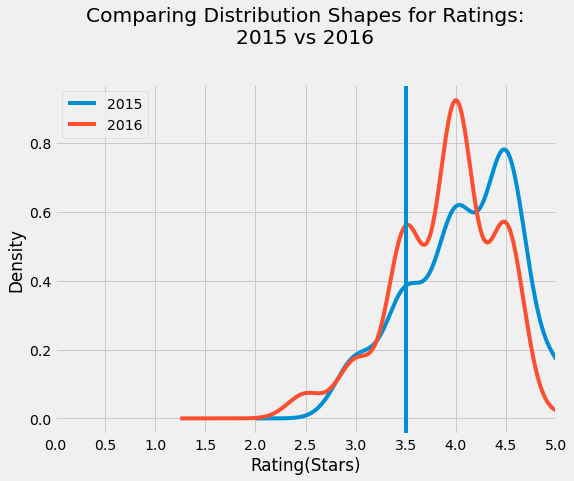

In [38]:
plt.style.use('fivethirtyeight')
fandango_2015['Fandango_Stars'].plot.kde(label='2015', legend=True, figsize=(8,6))
fandango_2016['fandango'].plot.kde(label='2016', legend=True)

plt.title('Comparing Distribution Shapes for Ratings:\n2015 vs 2016', y= 1.1)
plt.xlabel('Rating(Stars)')
plt.ylabel('Density')
plt.xlim(0,5)
plt.xticks(np.arange(0,5.1,0.5))
plt.axvline(3.5)
plt.show()

Observing these distributions one can see both are heavily left skewed. The left skew suggests that movies on Fandango are given mostly quite high fan ratings. Coupled with the fact that Fandango sells tickets, the high ratings are a bit dubious.

The slight left shift of the 2016 distribution shows that ratings were slightly lower in 2016 compared to 2015. This suggests that there was indeed a difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. The change did lowered the ratings while still in general having most movies rated above 3.5 stars(what many would term a "decent movie").

## Comparing Relative Frequencies

In [47]:
print('2015 Frequency Distribution(%)' + '\n' + '-'*30)

(fandango_2015['Fandango_Stars'].value_counts(
    normalize=True)*100).sort_index(ascending=False)


2015 Frequency Distribution(%)
------------------------------


5.0     6.976744
4.5    37.984496
4.0    28.682171
3.5    17.829457
3.0     8.527132
Name: Fandango_Stars, dtype: float64

In [48]:
print('2016 Frequency Distribution(%)' + '\n' + '-'*30)

(fandango_2016['fandango'].value_counts(
    normalize=True)*100).sort_index(ascending=False)

2016 Frequency Distribution(%)
------------------------------


5.0     0.523560
4.5    24.607330
4.0    40.314136
3.5    24.083770
3.0     7.329843
2.5     3.141361
Name: fandango, dtype: float64

In 2016, very high ratings (4.5 and 5 stars) had significantly lower percentages compared to 2015. In 2016, under 1% of the movies had a perfect rating of 5 stars, compared to almost 7% in 2015. There were approximately 13% more movies rated with a 4.5 in 2015 compared to 2016.

The minimum rating in 2015 was 3 stars but that went down to 2.5 in 2016. A large number of movies in 2016 (~40%) received 4 stars whereas in 2015 this share was about 28%. The frequency distribution tables imply that the change in rating system shifted ratings down a half-star, perhaps to a position they should have been initially.

## Determining the Direction of Change

Observing the summary statistics for each distribution. We calculate the mean, mode and median and compare.

In [54]:
mean_2015 = fandango_2015['Fandango_Stars'].mean()
mean_2016 = fandango_2016['fandango'].mean()

median_2015 = fandango_2015['Fandango_Stars'].median()
median_2016 = fandango_2016['fandango'].median()

mode_2015 = fandango_2015['Fandango_Stars'].mode()[0]
mode_2016 = fandango_2016['fandango'].mode()[0]

summary = pd.DataFrame()
summary['2015'] = [mean_2015, median_2015, mode_2015]
summary['2016'] = [mean_2016, median_2016, mode_2016]
summary.index = ['mean', 'median', 'mode']
summary

,2015,2016
mean,4.085271,3.887435
median,4.000000,4.000000
mode,4.500000,4.000000


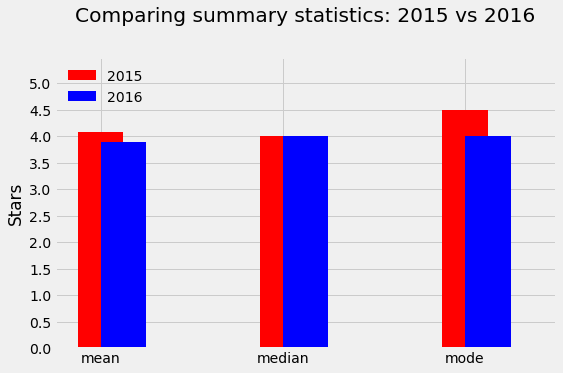

In [57]:
plt.style.use('fivethirtyeight')
summary['2015'].plot.bar(color = 'red', align = 'center', label = '2015', width = .25)
summary['2016'].plot.bar(color = 'blue', align = 'edge', label = '2016', width = .25,
                         rot = 0, figsize = (8,5))

plt.title('Comparing summary statistics: 2015 vs 2016', y = 1.1)
plt.ylim(0,5.5)
plt.yticks(np.arange(0,5.1,.5))
plt.ylabel('Stars')
plt.legend(framealpha = 0, loc = 'upper left')
plt.show()

While the median is the same for both distributions, the mode is lower in 2016 by 0.5. Coupled with what we saw for the mean, the direction of the change we saw on the kernel density plot is confirmed in that on average, popular movies released in 2016 were rated slightly lower than popular movies released in 2015.

## Conclusion

Our analysis showed that there is indeed a slight difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. We also determined that, on average, popular movies released in 2016 were rated lower on Fandango than popular movies released in 2015.

We cannot be completely sure what caused the change, but it could have been caused by Fandango fixing the perceived biased rating system following Hickey's analysis.